In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [11]:
df = pd.read_csv("ChicagoCrimeData.csv")


In [13]:
df['Date'] = pd.to_datetime(
    df['Date'],
    format='%m/%d/%Y %I:%M:%S %p',
    errors='coerce'
)

df = df.dropna(subset=['Date', 'District'])

monthly_district_crime = (
    df
    .set_index('Date')
    .groupby('District')
    .resample('M')
    .size()
    .reset_index(name='crime_count')
)

C:\Users\B Siddarth Vijayan\AppData\Local\Temp\ipykernel_32024\2268969219.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
C:\Users\B Siddarth Vijayan\AppData\Local\Temp\ipykernel_32024\2268969219.py:14: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


In [16]:
monthly_district_crime.head()


,District,Date,crime_count
0,1.0,2001-01-31,1298
1,1.0,2001-02-28,1122
2,1.0,2001-03-31,1333
3,1.0,2001-04-30,1207
4,1.0,2001-05-31,1175


In [18]:
monthly_district_crime['District'].nunique()


24

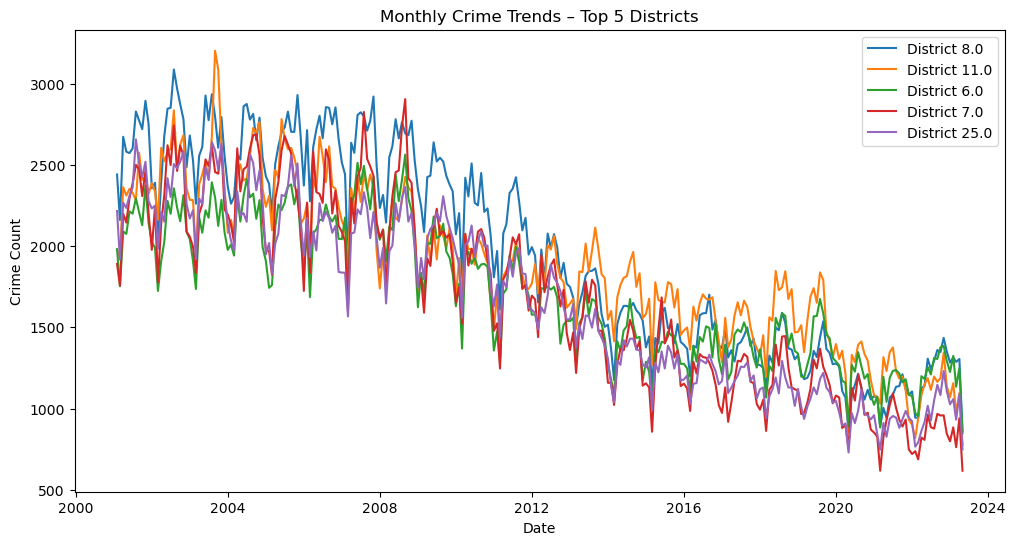

In [19]:
top_districts = (
    monthly_district_crime
    .groupby('District')['crime_count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plt.figure(figsize=(12,6))

for d in top_districts:
    subset = monthly_district_crime[monthly_district_crime['District'] == d]
    plt.plot(subset['Date'], subset['crime_count'], label=f'District {d}')

plt.legend()
plt.title("Monthly Crime Trends – Top 5 Districts")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.show()


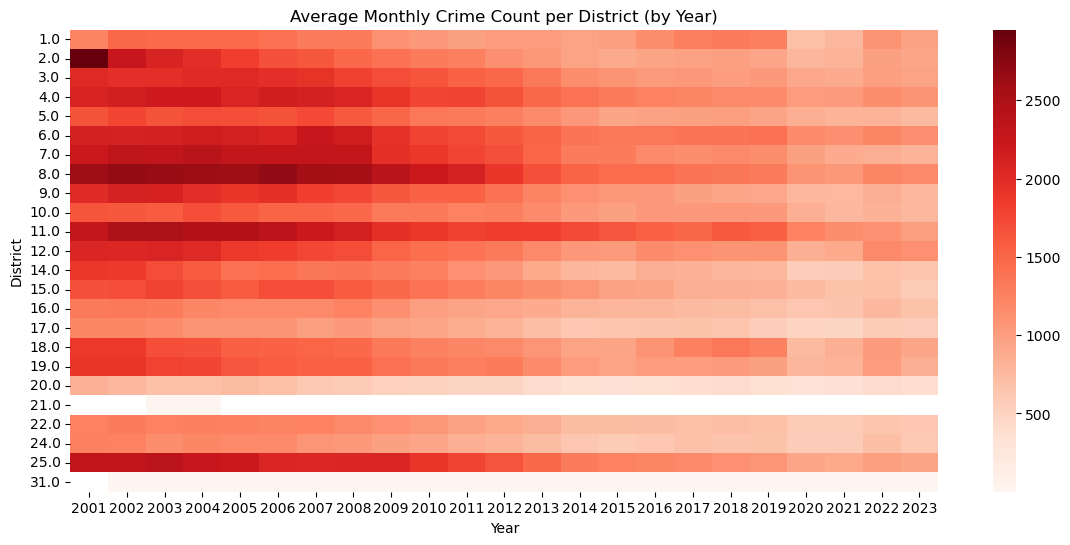

In [20]:
pivot_df = monthly_district_crime.pivot_table(
    index='District',
    columns=monthly_district_crime['Date'].dt.year,
    values='crime_count',
    aggfunc='mean'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot_df, cmap='Reds')
plt.title("Average Monthly Crime Count per District (by Year)")
plt.xlabel("Year")
plt.ylabel("District")
plt.show()


In [21]:
monthly_district_crime['month'] = monthly_district_crime['Date'].dt.month

seasonality = (
    monthly_district_crime
    .groupby(['District', 'month'])['crime_count']
    .mean()
    .reset_index()
)


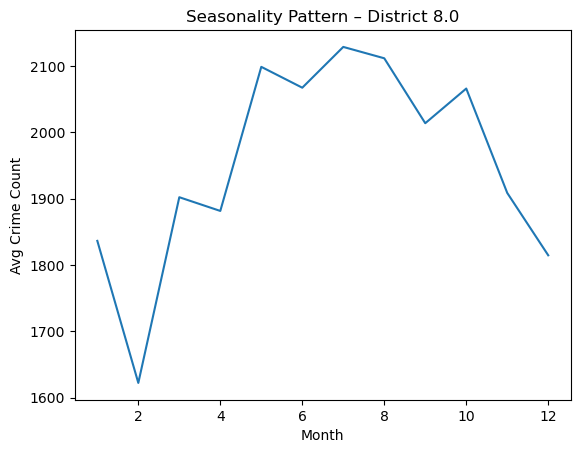

In [22]:
d = top_districts[0]

subset = seasonality[seasonality['District'] == d]
plt.plot(subset['month'], subset['crime_count'])
plt.title(f"Seasonality Pattern – District {d}")
plt.xlabel("Month")
plt.ylabel("Avg Crime Count")
plt.show()


In [23]:
monthly_district_crime = monthly_district_crime.sort_values(
    ['District', 'Date']
)


In [24]:
for lag in [1, 3, 12]:
    monthly_district_crime[f'lag_{lag}'] = (
        monthly_district_crime
        .groupby('District')['crime_count']
        .shift(lag)
    )


In [25]:
monthly_district_crime['roll_mean_3'] = (
    monthly_district_crime
    .groupby('District')['crime_count']
    .shift(1)
    .rolling(window=3)
    .mean()
)

monthly_district_crime['roll_std_3'] = (
    monthly_district_crime
    .groupby('District')['crime_count']
    .shift(1)
    .rolling(window=3)
    .std()
)


In [26]:
monthly_district_crime['month'] = monthly_district_crime['Date'].dt.month


In [27]:
model_df = monthly_district_crime.dropna().copy()

In [28]:
model_df.head()
model_df.columns


Index(['District', 'Date', 'crime_count', 'month', 'lag_1', 'lag_3', 'lag_12',
       'roll_mean_3', 'roll_std_3'],
      dtype='object')

In [29]:
split_date = model_df['Date'].quantile(0.8)

train = model_df[model_df['Date'] < split_date]
test  = model_df[model_df['Date'] >= split_date]


In [30]:
train['Date'].max(), test['Date'].min()


(Timestamp('2018-12-31 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [31]:
train.head()
test.head()

,District,Date,crime_count,month,lag_1,lag_3,lag_12,roll_mean_3,roll_std_3
216,1.0,2019-01-31,1181,1,1338.0,1275.0,1250.0,1253.666667,96.779819
217,1.0,2019-02-28,1141,2,1181.0,1148.0,1089.0,1222.333333,101.520113
218,1.0,2019-03-31,1191,3,1141.0,1338.0,1241.0,1220.000000,104.129727
219,1.0,2019-04-30,1225,4,1191.0,1181.0,1253.0,1171.000000,26.457513
220,1.0,2019-05-31,1376,5,1225.0,1141.0,1480.0,1185.666667,42.253205


In [32]:
y_train = train['crime_count']
y_test  = test['crime_count']

In [33]:
features = [
    'District',
    'month',
    'lag_1',
    'lag_3',
    'lag_12',
    'roll_mean_3',
    'roll_std_3'
]

X_train = train[features]
X_test  = test[features]


In [34]:
baseline_pred = test['lag_12']

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

baseline_mae, baseline_rmse

(123.96989966555184, np.float64(174.97408790482976))

In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [38]:
y_pred = xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

xgb_mae, xgb_rmse

(71.56725311279297, np.float64(105.69214766540134))

In [39]:
pd.DataFrame({
    'Model': ['Seasonal Naive', 'XGBoost'],
    'MAE': [baseline_mae, xgb_mae],
    'RMSE': [baseline_rmse, xgb_rmse]
})


,Model,MAE,RMSE
0,Seasonal Naive,123.969900,174.974088
1,XGBoost,71.567253,105.692148


In [40]:
test_results = test.copy()
test_results['y_true'] = y_test.values
test_results['y_pred'] = y_pred
test_results['abs_error'] = np.abs(test_results['y_true'] - test_results['y_pred'])

In [41]:
district_error = (
    test_results
    .groupby('District')['abs_error']
    .mean()
    .sort_values(ascending=False)
)

district_error.head(10)


District
1.0     158.428328
18.0    145.120120
12.0    103.995472
11.0     99.597572
19.0     89.644192
8.0      77.066621
14.0     73.824288
6.0      73.679362
7.0      70.616570
10.0     69.606238
Name: abs_error, dtype: float64

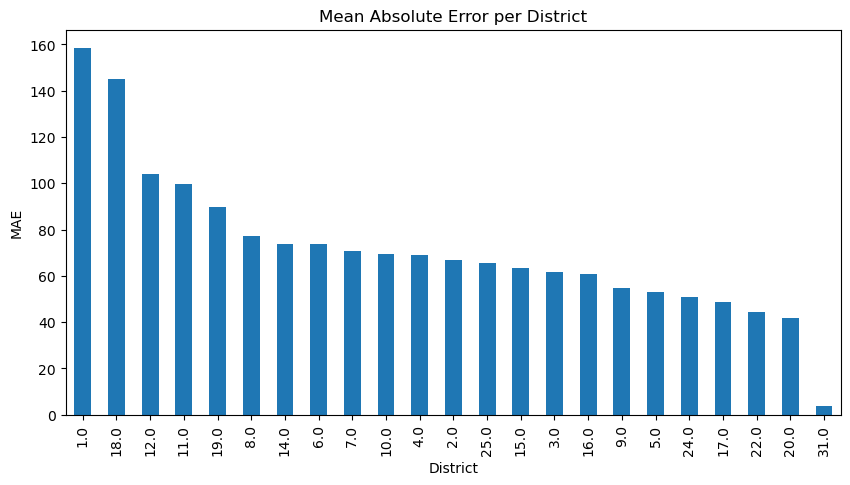

In [42]:
plt.figure(figsize=(10,5))
district_error.plot(kind='bar')
plt.title("Mean Absolute Error per District")
plt.ylabel("MAE")
plt.xlabel("District")
plt.show()


In [44]:
district_population = (
    monthly_district_crime
    .groupby('District')['crime_count']
    .mean()
    .apply(lambda x: int(60000 + x))  # proxy population
    .to_dict()
)


In [45]:
test_results['population'] = test_results['District'].map(district_population)

test_results['crime_rate_true'] = (
    test_results['y_true'] / test_results['population'] * 1000
)

test_results['crime_rate_pred'] = (
    test_results['y_pred'] / test_results['population'] * 1000
)


In [46]:
test_results[['District', 'crime_rate_true', 'crime_rate_pred']].head()

,District,crime_rate_true,crime_rate_pred
216,1.0,19.305903,21.249132
217,1.0,18.652020,17.040830
218,1.0,19.469374,21.061979
219,1.0,20.025175,20.415363
220,1.0,22.493584,22.546965


In [49]:
FORECAST_HORIZON = 6


In [50]:
last_known = (
    model_df
    .sort_values('Date')
    .groupby('District')
    .tail(1)
    .copy()
)


In [53]:
FORECAST_HORIZON = 6

future_predictions = []

current_data = last_known.copy()

for step in range(FORECAST_HORIZON):
    
    # Month feature
    current_data['month'] = current_data['Date'].dt.month
    
    # Predict
    X_future = current_data[features]
    current_data['predicted_crime'] = xgb.predict(X_future)
    
    # Store prediction
    future_predictions.append(
        current_data[['District', 'Date', 'predicted_crime']].copy()
    )
    
    # Move to next month (FIXED)
    current_data['Date'] = current_data['Date'] + pd.DateOffset(months=1)
    
    # Update lags (CORRECT LOGIC)
    current_data['lag_12'] = current_data['lag_11'] if 'lag_11' in current_data.columns else current_data['lag_12']
    current_data['lag_3']  = current_data['lag_1']
    current_data['lag_1']  = current_data['predicted_crime']
    
    # Update rolling stats
    current_data['roll_mean_3'] = (
        current_data[['lag_1', 'lag_3', 'lag_12']].mean(axis=1)
    )
    
    current_data['roll_std_3'] = (
        current_data[['lag_1', 'lag_3', 'lag_12']].std(axis=1)
    )


In [54]:
future_df = pd.concat(future_predictions, ignore_index=True)


In [55]:
future_df.head()


,District,Date,predicted_crime
0,21.0,2004-08-31,9.502268
1,11.0,2023-04-30,1135.086548
2,9.0,2023-04-30,825.175781
3,3.0,2023-04-30,1066.915771
4,2.0,2023-04-30,921.148560


In [56]:
future_df['population'] = future_df['District'].map(district_population)

future_df['predicted_crime_rate'] = (
    future_df['predicted_crime'] / future_df['population'] * 1000
)


In [57]:
future_df.head()

,District,Date,predicted_crime,population,predicted_crime_rate
0,21.0,2004-08-31,9.502268,60000,0.158371
1,11.0,2023-04-30,1135.086548,61864,18.348095
2,9.0,2023-04-30,825.175781,61419,13.435188
3,3.0,2023-04-30,1066.915771,61473,17.355844
4,2.0,2023-04-30,921.148560,61374,15.008775


In [58]:
district_risk = (
    future_df
    .groupby('District')['predicted_crime_rate']
    .mean()
    .sort_values(ascending=False)
)


In [59]:
district_risk.head(5)


District
8.0     20.245564
6.0     20.113290
11.0    18.890732
4.0     17.829370
12.0    17.797888
Name: predicted_crime_rate, dtype: float64

In [60]:
district_risk.tail(5)


District
22.0    10.188174
17.0     8.838654
20.0     5.880418
21.0     0.404811
31.0     0.046671
Name: predicted_crime_rate, dtype: float64

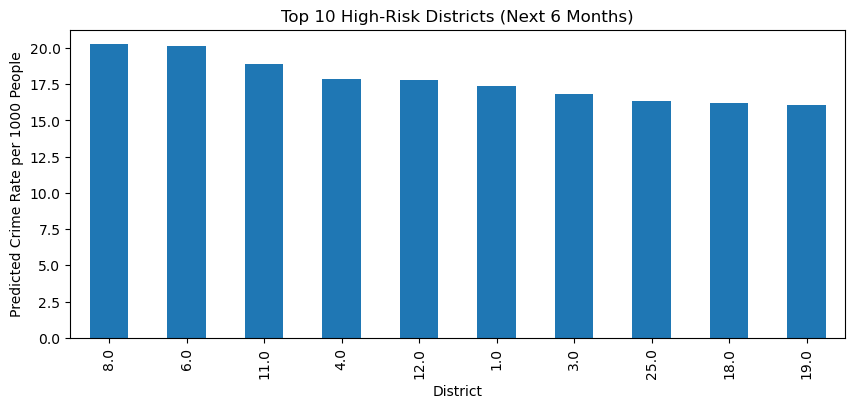

In [61]:
plt.figure(figsize=(10,4))
district_risk.head(10).plot(kind='bar')
plt.title("Top 10 High-Risk Districts (Next 6 Months)")
plt.ylabel("Predicted Crime Rate per 1000 People")
plt.xlabel("District")
plt.show()
